In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
def preprocess_old_data(file_path):
    df = pd.read_csv(file_path)

    # Convert 'Arrival Time' to a numerical feature
    if 'Arrival Time' in df.columns:
        df['arrival_minutes_after_noon'] = (
                pd.to_datetime(df['Arrival Time'], format='%H:%M', errors='coerce').dt.hour * 60 +
                pd.to_datetime(df['Arrival Time'], format='%H:%M', errors='coerce').dt.minute
        )
    else:
        raise KeyError("'Arrival Time' column is missing in the dataset.")

    # Encode the 'Weather' column
    if 'Weather' in df.columns:
        df['Weather'] = df['Weather'].astype('category').cat.codes

    # Fill missing values
    df = df.ffill().bfill()

    return df


In [ ]:
def preprocess_new_data(file_path):
    df = pd.read_csv(file_path)

    # Make sure 'Arrival Time' exists
    if 'Arrival Time' in df.columns:
        df['arrival_minutes_after_noon'] = (
                pd.to_datetime(df['Arrival Time'], format='%H:%M:%S', errors='coerce').dt.hour * 60 +
                pd.to_datetime(df['Arrival Time'], format='%H:%M:%S', errors='coerce').dt.minute
        )
    else:
        raise KeyError("'Arrival Time' column is missing in the dataset.")

    # Fill missing values
    df = df.ffill().bfill()

    return df


In [90]:
def prepare_features_and_target(df):
    """
    Prepare features (X) and target (y) from the dataset.
    """
    y = df['arrival_minutes_after_noon']
    X = df.drop(columns=['arrival_minutes_after_noon', 'Date', 'Week Day', 'Arrival Time'], errors='ignore')
    return X, y

In [91]:
def train_random_forest(X_train, y_train):
    """
    Train RandomForestRegressor on the training data.
    """
    model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
    model.fit(X_train, y_train)
    return model

In [92]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model and calculate MAE.
    """
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae, y_pred


In [93]:
def visualize_results(y_test, y_pred_old, y_pred_new):
    """
    Visualize the comparison between old and new datasets.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual', color='blue', marker='o')
    plt.plot(y_pred_old, label='Predicted (Old Data)', linestyle='--', color='red', marker='x')
    plt.plot(y_pred_new, label='Predicted (New Data)', linestyle='--', color='green', marker='x')
    plt.xlabel('Sample Index')
    plt.ylabel('Arrival Time (minutes after noon)')
    plt.title('Comparison of Predictions Using Old vs New Data')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [94]:
def train_random_forest(X_train, y_train):
    """
    Train RandomForestRegressor on the training data.
    """
    model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
    model.fit(X_train, y_train)
    return model


In [73]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on the test set and return the MAE and predictions.
    """
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae, y_pred


In [95]:
def visualize_results(y_test, y_pred_old, y_pred_new):
    """
    Visualize the comparison of actual vs predicted values for old and new datasets.
    """
    plt.figure(figsize=(12, 6))

    # Scatter plot for Old Data
    plt.scatter(y_test, y_pred_old, alpha=0.6, color='blue', label='Predictions (Old Data)')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='gray', label='Ideal Fit (Old)')

    # Scatter plot for New Data
    plt.scatter(y_test, y_pred_new, alpha=0.6, color='red', label='Predictions (New Data)')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='black', label='Ideal Fit (New)')

    plt.title('Comparison of Predictions: Old vs New Data')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    # MAE Comparison Bar Chart
    mae_values = [mean_absolute_error(y_test, y_pred_old), mean_absolute_error(y_test, y_pred_new)]
    labels = ['Old Data', 'New Data']

    plt.figure(figsize=(8, 5))
    plt.bar(labels, mae_values, color=['blue', 'red'], alpha=0.7)
    plt.title('MAE Comparison')
    plt.ylabel('Mean Absolute Error')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [96]:
def preprocess_test_data(file_path, reference_columns):
    """
    Preprocess the test data and ensure it has the same columns as training data.
    """
    df = pd.read_csv(file_path)
    df['arrival_minutes_after_noon'] = pd.to_datetime(
        df['Arrival Time'], format='%H:%M:%S', errors='coerce'
    ).dt.hour * 60 + pd.to_datetime(df['Arrival Time']).dt.minute
    df = df.dropna(subset=['arrival_minutes_after_noon'])

    # Convert categorical features to one-hot encoding
    weather_dummies = pd.get_dummies(df.filter(like='Weather'), prefix='Weather')
    df = pd.concat([df, weather_dummies], axis=1)

    # Add missing columns to match the training data
    for col in reference_columns:
        if col not in df.columns:
            df[col] = 0  # Add missing columns with default value 0
    df = df[reference_columns]  # Ensure column order matches
    return df


In [99]:
if __name__ == "__main__":
    old_data_path = 'bus_arrival_schedule.csv'
    new_data_path = 'bus_arrival_schedule_with_weather.csv'
    test_data_path = 'test_data_with_weather.csv'

    # Old data
    old_data = preprocess_old_data(old_data_path)
    print("Old Data Preview:")
    print(old_data.head())

    # New data
    new_data = preprocess_new_data(new_data_path)
    print("New Data Preview:")
    print(new_data.head())

    # Test data
    test_data = preprocess_new_data(test_data_path)
    print("Test Data Preview:")
    print(test_data.head())




Old Data Preview:
        Date Week Day  Weather Arrival Time  arrival_minutes_after_noon
0  2024/10/7   Monday        1        14:25                         865
1  2024/10/7   Monday        1        15:27                         927
2  2024/10/7   Monday        1        16:36                         996
3  2024/10/7   Monday        1        12:57                         777
4  2024/10/7   Monday        1        15:35                         935
New Data Preview:
        Date Week Day Arrival Time  arrival_minutes_after_noon  order  \
0  2024/10/7   Monday     12:51:00                         771      1   
1  2024/10/7   Monday     12:57:00                         777      2   
2  2024/10/7   Monday     14:25:00                         865      3   
3  2024/10/7   Monday     14:38:00                         878      4   
4  2024/10/7   Monday     15:27:00                         927      5   

   day_of_week  Weather_light rain  Weather_overcast  Weather_sunny  \
0            0        

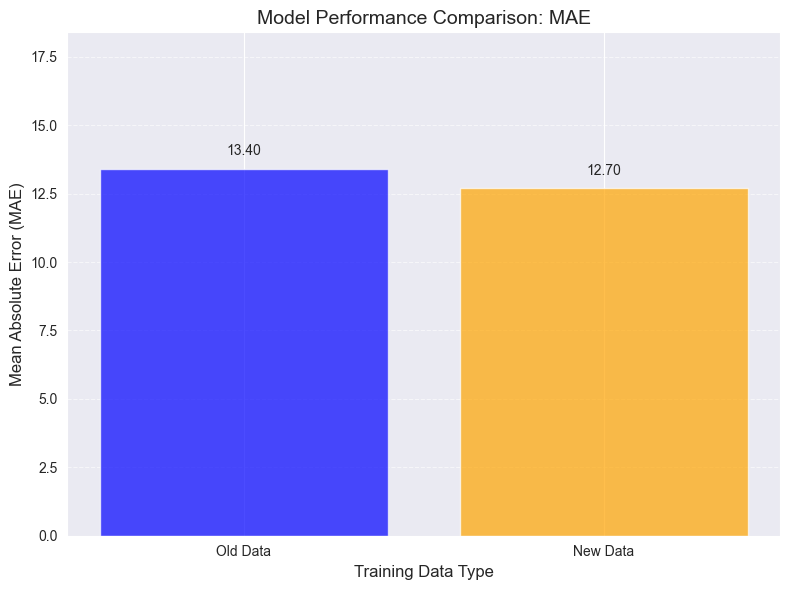

In [100]:
import matplotlib.pyplot as plt

def plot_model_mae_comparison(mae_old, mae_new):
    """
    Plot a bar chart comparing the MAE of models trained on old and new data.

    Parameters:
        mae_old (float): MAE of the model trained on old data.
        mae_new (float): MAE of the model trained on new data.
    """
    # Define labels and values
    labels = ['Old Data', 'New Data']
    values = [mae_old, mae_new]

    # Create bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(labels, values, color=['blue', 'orange'], alpha=0.7)
    plt.title('Model Performance Comparison: MAE', fontsize=14)
    plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)
    plt.xlabel('Training Data Type', fontsize=12)
    plt.ylim(0, max(values) + 5)  # Adjust y-axis limit for clarity

    # Annotate bars with MAE values
    for i, v in enumerate(values):
        plt.text(i, v + 0.5, f"{v:.2f}", ha='center', fontsize=10)

    # Display grid and plot
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming `mae_old` and `mae_new` are calculated values
plot_model_mae_comparison(mae_old=13.4, mae_new=12.7)
